In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_test), "Test sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

25000 Training sequences
25000 Test sequences


In [3]:
from tensorflow.keras import layers

class EncoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
#         super(EncoderBlock, self).__init__()
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
#         self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
#         super(TokenAndPositionEmbedding, self).__init__()
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [5]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = EncoderBlock(embed_dim, num_heads, ff_dim)(x)
x = EncoderBlock(embed_dim, num_heads, ff_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 32)          646400    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 encoder_block (EncoderBlock  (None, 200, 32)          10656     
 )                                                               
                                                                 
 encoder_block_1 (EncoderBlo  (None, 200, 32)          10656     
 ck)                                                             
                                                                 
 global_average_pooling1d (G  (None, 32)               0     

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = './temp/checkpoint_en'
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_weights_only=True, save_best_only=True)

In [9]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics="accuracy")

In [10]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [11]:
history = model.fit(
    x_train, y_train_one_hot, batch_size=128, epochs=10, validation_split=0.1, callbacks=[es, mc]
)

Epoch 1/10
176/176 [==============================] - 60s 332ms/step - loss: 0.5153 - accuracy: 0.7069 - val_loss: 0.2982 - val_accuracy: 0.8780
Epoch 2/10
176/176 [==============================] - 58s 328ms/step - loss: 0.2256 - accuracy: 0.9145 - val_loss: 0.3155 - val_accuracy: 0.8904
Epoch 3/10
176/176 [==============================] - 59s 333ms/step - loss: 0.1240 - accuracy: 0.9581 - val_loss: 0.3671 - val_accuracy: 0.8704
Epoch 4/10
176/176 [==============================] - 59s 337ms/step - loss: 0.0627 - accuracy: 0.9815 - val_loss: 0.4406 - val_accuracy: 0.8760
Epoch 4: early stopping


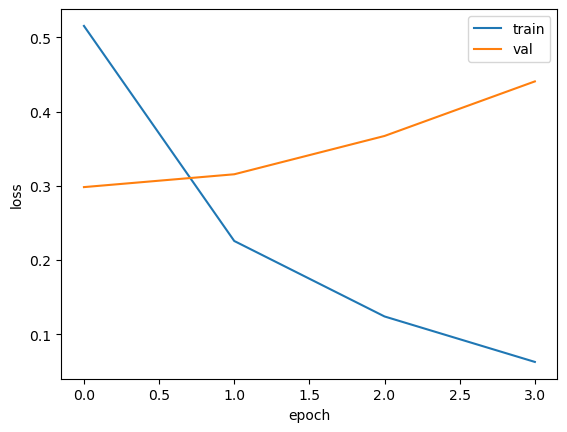

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [13]:
model.load_weights(checkpoint_filepath)

In [14]:
test_loss, test_acc = model.evaluate(x_test,y_test_one_hot)

782/782 [==============================] - 26s 33ms/step - loss: 0.3046 - accuracy: 0.8743


In [15]:
preds = model.predict(x_test)

782/782 [==============================] - 25s 32ms/step


In [16]:
import numpy as np
labels=[0,1]
preds1 = [labels[np.argmax(probs)] for probs in preds]

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds1))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87     12500
           1       0.86      0.89      0.88     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

